In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, roc_auc_score,
    precision_recall_curve, auc, accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from mpl_toolkits.mplot3d import Axes3D


In [12]:
# Load dataset
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [13]:
# Drop unused features and separate target
X = data.drop([
    'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
    'platelets', 'sex', 'smoking', 'DEATH_EVENT', 'time'
], axis=1)
y = data['DEATH_EVENT']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


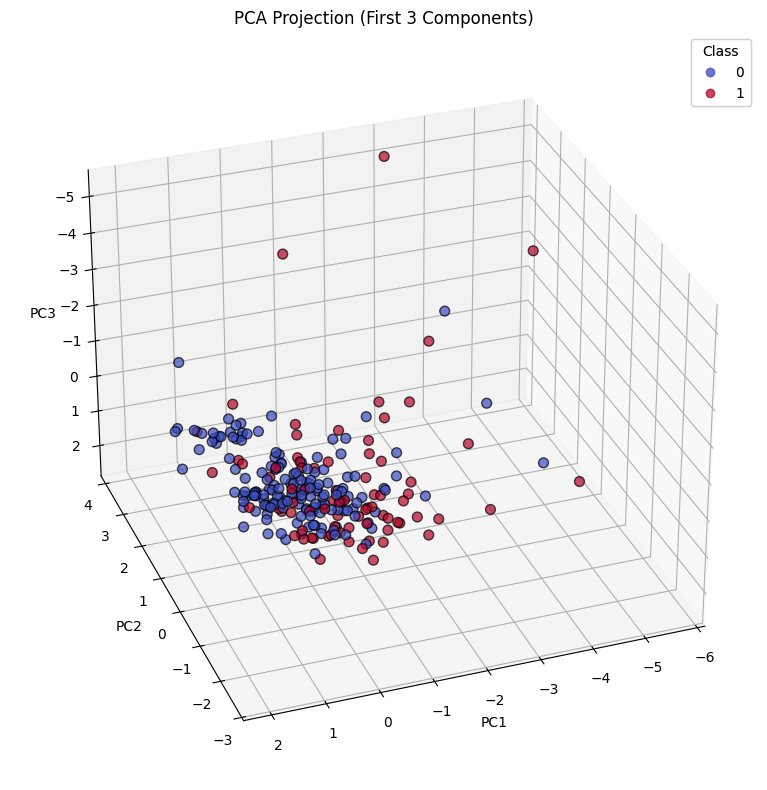

PCA explained variance ratio: [0.31605897 0.28059906 0.21227771 0.19106425]
Total variance explained by 4 components: 100.00%


In [14]:
# --- PCA ---
n_components = min(X_train.shape[1], 6)
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# --- 3D PCA Visualization ---
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_train)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
scatter = ax.scatter(
    X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
    c=y_train, cmap=plt.cm.coolwarm, edgecolor='k', s=50, alpha=0.7
)
ax.set_title("PCA Projection (First 3 Components)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
legend1 = ax.legend(*scatter.legend_elements(), title="Class")
ax.add_artist(legend1)
plt.tight_layout()
plt.show()

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained by {n_components} components: {np.sum(pca.explained_variance_ratio_):.2%}")

In [15]:
# --- Class Weights ---
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# --- Neural Network Model ---
model = Sequential([
    Dense(128, input_shape=(X_train_pca.shape[1],), kernel_regularizer=regularizers.l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, kernel_regularizer=regularizers.l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, kernel_regularizer=regularizers.l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, kernel_regularizer=regularizers.l2(0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0003)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)
early_stop = EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True)


/home/uta/Coding/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/uta/Coding/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [16]:
# Train Neural Network with class weights
history = model.fit(
    X_train_pca, y_train,
    epochs=600,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weights
)

# --- Decision Tree ---
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train_pca, y_train)
y_pred_dt = dt.predict(X_test_pca)
y_pred_dt_prob = dt.predict_proba(X_test_pca)[:, 1]

# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_pca, y_train)
y_pred_rf = rf.predict(X_test_pca)
y_pred_rf_prob = rf.predict_proba(X_test_pca)[:, 1]

Epoch 1/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4373 - auc_1: 0.4604 - loss: 1.0718 - val_accuracy: 0.5833 - val_auc_1: 0.5162 - val_loss: 0.8492
Epoch 2/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4209 - auc_1: 0.6097 - loss: 0.9388 - val_accuracy: 0.6250 - val_auc_1: 0.6030 - val_loss: 0.8395
Epoch 3/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4976 - auc_1: 0.6364 - loss: 0.9413 - val_accuracy: 0.6667 - val_auc_1: 0.6545 - val_loss: 0.8272
Epoch 4/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5083 - auc_1: 0.6309 - loss: 0.8826 - val_accuracy: 0.7083 - val_auc_1: 0.7222 - val_loss: 0.8163
Epoch 5/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4859 - auc_1: 0.6313 - loss: 0.8884 - val_accuracy: 0.7292 - val_auc_1: 0.7293 - val_loss: 0.8081
Epoch 6/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6144 - auc_1: 0.7221 - loss: 0.8382 - val_accuracy: 0.7500 - val_auc_1: 0.7343 - val_loss: 0.8032
Epoch 7/600
12/12 ━━

In [17]:
# Evaluate Neural Network
loss, accuracy, auc_roc = model.evaluate(X_test_pca, y_test, verbose=0)
print("=== Neural Network ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1_score(y_test, (model.predict(X_test_pca).ravel() > 0.5).astype('int32')):.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
y_pred_prob = model.predict(X_test_pca).ravel()
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.4f}")
print("Classification Report:\n", classification_report(y_test, (y_pred_prob > 0.5).astype("int32")))
print("Confusion Matrix:\n", confusion_matrix(y_test, (y_pred_prob > 0.5).astype("int32")))

# Evaluate Decision Tree
print("\n=== Decision Tree ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_dt):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_dt_prob):.4f}")
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_pred_dt_prob)
auc_pr_dt = auc(recall_dt, precision_dt)
print(f"AUC-PR: {auc_pr_dt:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

# Evaluate Random Forest
print("\n=== Random Forest ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_rf_prob):.4f}")
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf_prob)
auc_pr_rf = auc(recall_rf, precision_rf)
print(f"AUC-PR: {auc_pr_rf:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

=== Neural Network ===
Accuracy: 0.7667
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
F1-Score: 0.6667
AUC-ROC: 0.8235
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
AUC-PR: 0.6539
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82        41
           1       0.61      0.74      0.67        19

    accuracy                           0.77        60
   macro avg       0.74      0.76      0.74        60
weighted avg       0.78      0.77      0.77        60

Confusion Matrix:
 [[32  9]
 [ 5 14]]

=== Decision Tree ===
Accuracy: 0.6167
F1-Score: 0.4103
AUC-ROC: 0.5642
AUC-PR: 0.5022
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.71      0.72        41
           1       0.40      0.42      0.41        19

    accuracy                           0.62        60
   macro avg       0.56      0.56      0.56        60
weighted avg       0.62      0.62      0.62        60

Confusi

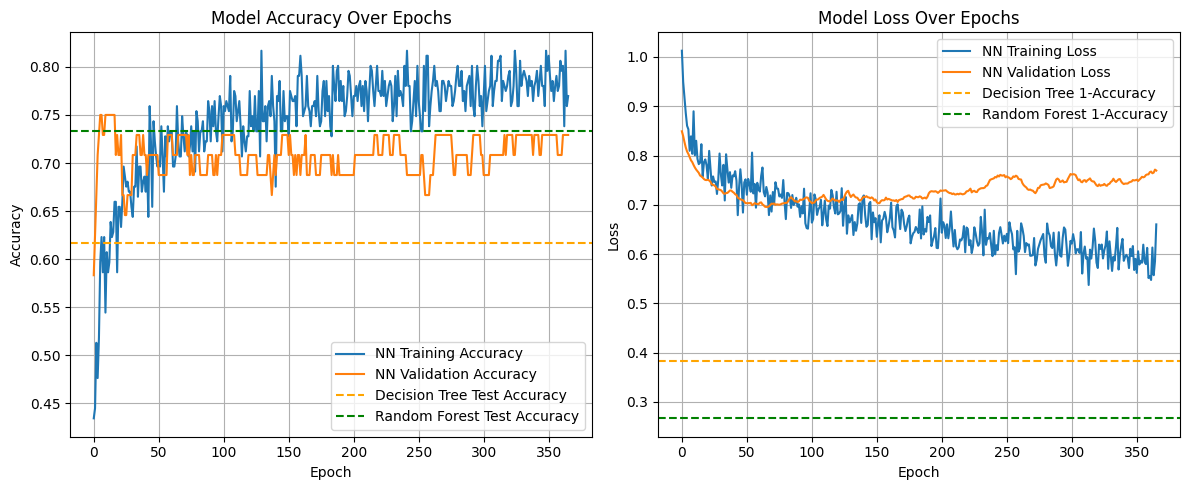

In [18]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='NN Training Accuracy')
plt.plot(history.history['val_accuracy'], label='NN Validation Accuracy')
plt.axhline(y=accuracy_score(y_test, y_pred_dt), color='orange', linestyle='--', label='Decision Tree Test Accuracy')
plt.axhline(y=accuracy_score(y_test, y_pred_rf), color='green', linestyle='--', label='Random Forest Test Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# --- Loss Plot ---
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='NN Training Loss')
plt.plot(history.history['val_loss'], label='NN Validation Loss')
# For scikit-learn models, you can plot 1-accuracy as a proxy for "loss"
plt.axhline(y=1-accuracy_score(y_test, y_pred_dt), color='orange', linestyle='--', label='Decision Tree 1-Accuracy')
plt.axhline(y=1-accuracy_score(y_test, y_pred_rf), color='green', linestyle='--', label='Random Forest 1-Accuracy')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
# --- Save Models and Scaler ---
model.save('heart_failure_nn_model.h5')
joblib.dump(scaler, 'scaler.save')
joblib.dump(dt, 'decision_tree_model.save')
joblib.dump(rf, 'random_forest_model.save')

['random_forest_model.save']